<a href="https://colab.research.google.com/github/ubermenchh/fun/blob/main/diffusers_course/diffusion_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning

## Setup and Imports

In [1]:
%pip install -qq diffusers datasets accelerate wandb open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 32.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.8

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

## Loading a Pre-Trained Pipeline

In [6]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

(…)lebahq-256/resolve/main/model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

(…)2668051904ead6cc120739b86c4d/config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

(…)ead6cc120739b86c4d/scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.21.4",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [7]:
image_pipe

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.21.4",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [8]:
images = image_pipe().images

  0%|          | 0/1000 [00:00<?, ?it/s]

[<PIL.Image.Image image mode=RGB size=256x256>]

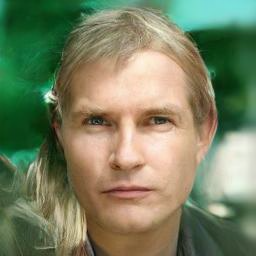

In [13]:
images[0]

## Faster Sampling with DDIM

In [9]:
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

In [14]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

0it [00:00, ?it/s]

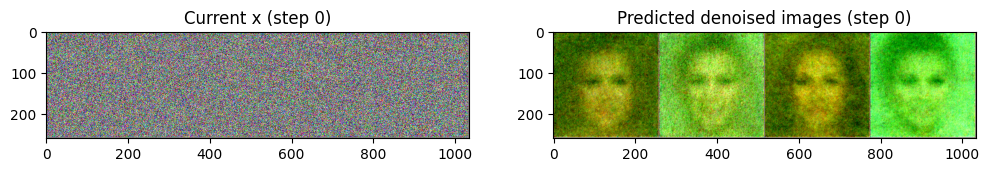

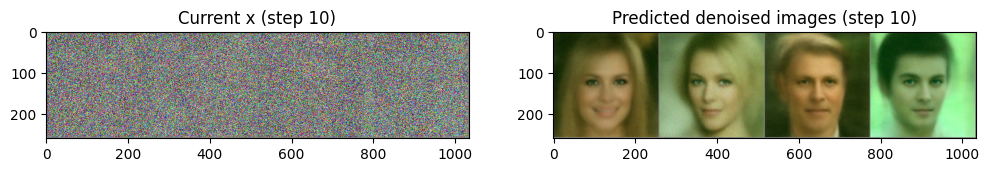

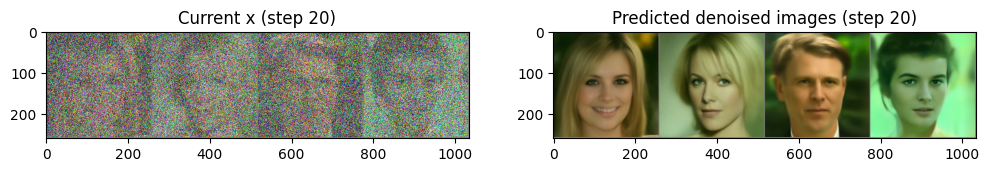

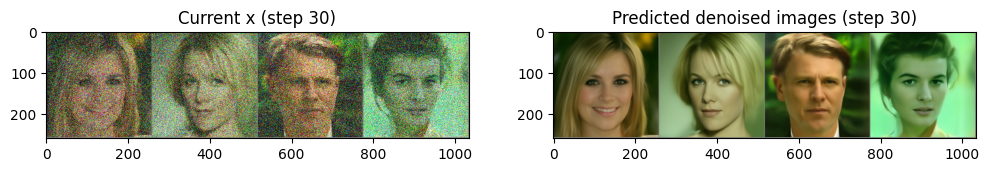

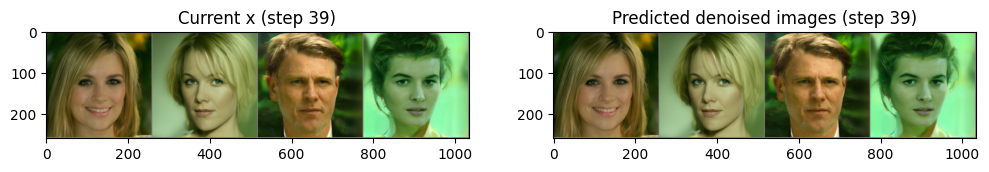

In [16]:
# the random starting point
x = torch.randn(4, 3, 256, 256).to(device)

# loop through the sampling timesteps
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # prepare model input
    model_input = scheduler.scale_model_input(x, t)

    # get the prediction
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)['sample']

    # calculate what the updated sample should look like with the scheduler
    scheduler_output = scheduler.step(noise_pred, t, x)

    # update x
    x = scheduler_output.prev_sample

    # occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = scheduler_output.pred_original_sample
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

In [20]:
scheduler.step??

  0%|          | 0/40 [00:00<?, ?it/s]

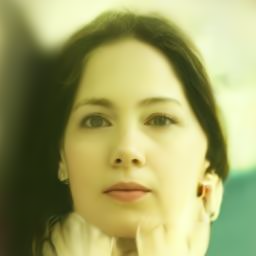

In [21]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

Repo card metadata block was not found. Setting CardData to empty.


Previewing Batch: 


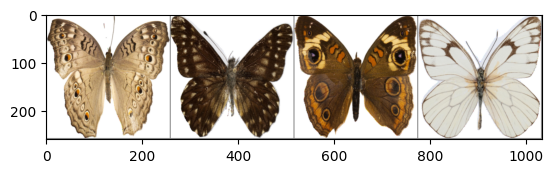

In [26]:
#@markdown load and prepare a dataset

dataset_name = "huggan/smithsonian_butterflies_subset" # @param
dataset = load_dataset(dataset_name, split='train')
image_size = 256 # @param
batch_size = 4 # @param
preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def transform(examples):
    images = [preprocess(image.convert('RGB')) for image in examples['image']]
    return {'images': images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Previewing Batch: ")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch['images'], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 0 Average Loss: 0.016971473518176936


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 Average Loss: 0.01092225462134229


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2 Average Loss: 0.012684024884132668


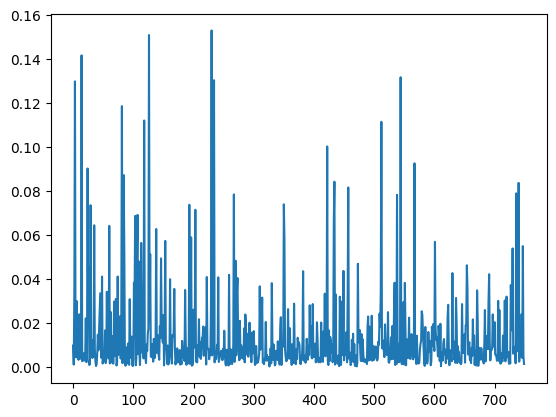

In [27]:
num_epochs = 3 # @param
lr = 1e-5 # @param
grad_accumulation_steps = 2 # @param

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch['images'].to(device)

        # sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # sample a random timestep for each image
        timesteps = torch.randint(0, image_pipe.scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

        # add noise to the clean images according to the noise magnitude at each timestep
        # FORWARD DIFFUSION PROCESS
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # get the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # compare the prediction with the actual noise
        loss = F.mse_loss(noise_pred, noise)

        losses.append(loss.item())
        # update the model parameters
        loss.backward(loss)

        # Gradient Accumulation
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch} Average Loss: {sum(losses[-len(train_dataloader):]) / len(train_dataloader)}")

plt.plot(losses)

In [30]:
!pip install -q wandb
import wandb

In [31]:
%wandb johnowhitaker/dm_finetune/2upaa341

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


0it [00:00, ?it/s]

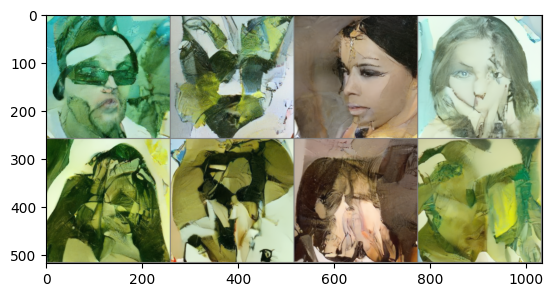

In [28]:
x = torch.randn(8, 3, 256, 256).to(device)
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)['sample']
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

## Saving and Loading Fine-Tuned Pipelines

In [32]:
image_pipe.save_pretrained('my-finetuned-models')

In [33]:
!ls {'my-finetuned-models'}

model_index.json  scheduler  unet


In [36]:
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

model_name = "ddpm-celebahq-finetuned-butterflies-2epochs"
local_folder_name = 'my-finetuned-models'
description = ' '
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(folder_path=f"{local_folder_name}/scheduler", path_in_repo='', repo_id=hub_model_id)
api.upload_folder(folder_path=f"{local_folder_name}/unet", path_in_repo='', repo_id=hub_model_id)
api.upload_file(path_or_fileobj=f"{local_folder_name}/model_index.json", path_in_repo="model_index.json", repo_id=hub_model_id)

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Example Fine-Tuned Model for Unit 2 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

{description}

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/ubermenchh/ddpm-celebahq-finetuned-butterflies-2epochs/blob/main/README.md'

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

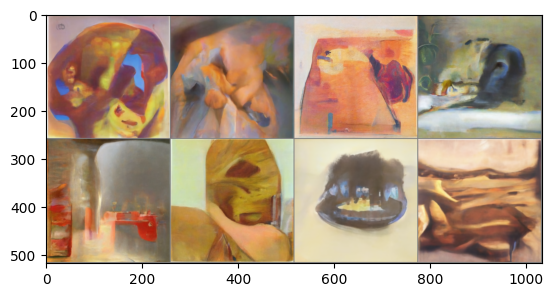

In [4]:
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)['sample']
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);